<div class="alert alert-info">

**Note:**
    
You can run this Notebook in Google Colab: https://colab.research.google.com/github/MiniXC/simple-back/blob/master/docs/intro/slippage.ipynb

</div>


# Strategy Objects & Slippage
**simple-back** backtests might be too optimistic, in reality you will hardly ever purchase securities at the exact open or close price. To help with this, you can use `slippage`. But first, let's turn our backtest from before into its own object.

In [3]:
%%capture
!pip install --upgrade simple_back

In [1]:
from simple_back.strategy import Strategy

## Strategy Object for our Moving Average from Before

In [2]:
class MAStrategy(Strategy):
    def __init__(self, ticker, ma_days, cool_days=60, no_log=False):
        self.ticker = ticker
        self.ma_days = ma_days # length of the MA
        self.cool_days = cool_days # length of the cooldown period
        self.no_log = no_log
        
    @property
    def name(self):
        return f"{self.ticker} - MA ({self.ma_days} days), CD ({self.cool_days} days)"
        
    def run(self, day, event, b):
        if event == 'open':
            ma = b.prices[self.ticker,-self.ma_days:]['close'].mean()
            b.add_metric('Price', b.price(self.ticker))
            b.add_metric(f'MA ({self.ma_days} Days)', ma)

            last_pos_date = b.portfolio.attr('date')
            if last_pos_date is None:
                date_diff = self.cool_days
            else:
                date_diff = (day - last_pos_date).days

            if date_diff >= self.cool_days and b.portfolio.value >= 0:
                if b.price(self.ticker) > ma:
                    if not b.portfolio[self.ticker].long: # check if we already are long
                        if not self.no_log:
                            b.log(f'long {self.ticker}')
                        b.portfolio[self.ticker].short.liquidate() # liquidate any/all short positions
                        b.long(self.ticker, percent=1) # long

                if b.price(self.ticker) < ma:
                    if not b.portfolio[self.ticker].short: # check if we already are short
                        if not self.no_log:
                            b.log(f'short {self.ticker}')
                        b.portfolio[self.ticker].long.liquidate() # liquidate any/all long positions
                        b.short(self.ticker, percent=1) # short

Now we can use our strategy from before, but can easily compare how it performs with different tickers, MA lengths or different lengths of the cooldown period.

## Running Strategies
We can run several strategies without iterating using ``run``.

In [3]:
from simple_back.backtester import BacktesterBuilder

builder = (
   BacktesterBuilder()
   .balance(10_000)
   .calendar('NYSE')
   .strategies([
       MAStrategy('JNUG',10),
       MAStrategy('JNUG',50),
       MAStrategy('JNUG',100),
    ]) # strategies to run
   .live_progress() # show a progress bar using tqdm
   .live_plot() # we assume we are running this in a Jupyter Notebook
)

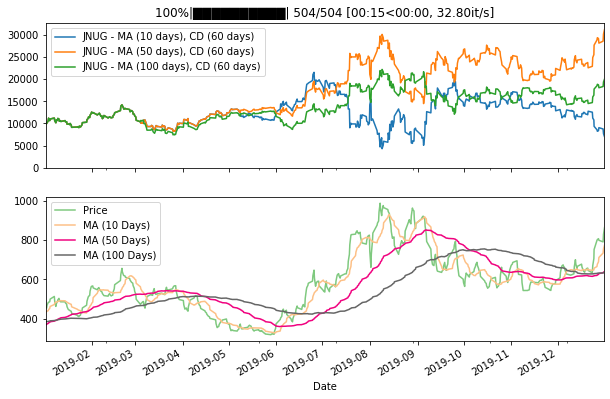

,,log
date,event,
2019-01-02 00:00:00,open,long JNUG
2019-03-04 00:00:00,open,short JNUG
2019-05-08 00:00:00,open,long JNUG
2019-07-09 00:00:00,open,short JNUG
2019-09-17 00:00:00,open,long JNUG
2019-11-22 00:00:00,open,short JNUG
,,log
date,event,
2019-01-02 00:00:00,open,long JNUG


In [4]:
bt = builder.build()
bt['2019-1-1':'2020-1-1'].run()

<div class="alert alert-info">

**Note:**
    
The dataframes below the plot are generated because we now use ``.log`` instead of ``.add_line`` as the lines of the different backtests would just overlap.

</div>

## Slippage
The more often trades are executed, the more slippage can become a problem. To visualize this, we can simply use `.slippage`, now with just one strategy.

<div class="alert alert-info">

**Note:**
    
Slippage is set to 0.05% per default, which is [the same quantopian uses for US Equities](https://www.quantopian.com/posts/changes-coming-to-the-default-slippage-model) (as of 06-2020).
</div>

In [5]:
bt = builder.strategies([MAStrategy('JNUG',10)]).no_live_progress().no_live_plot().slippage().build()
bt['2019-1-1':'2020-1-1'].run()

This is not a display error, we just trade so little that slippage is hardly noticeable. To get the exact difference, we can look at the *summary* again, where we can spot that slippage only causes 1% less in total return.

In [6]:
bt.summary

,Max Drawdown (%),Annual Return,Portfolio Value (Last Value),Total Value (Last Value),Total Return (%) (Last Value),Daily Profit/Loss (Last Value)
Backtest,,,,,,
"JNUG - MA (10 days), CD (60 days) (lower bound)",-80.370444,0.767375,7386.879668,7686.275872,-23.137241,88.579424
"JNUG - MA (10 days), CD (60 days)",-80.125384,0.775959,7410.557799,7771.721211,-22.282788,88.535156


But what if we trade more often? Let's set the cooldown period to 0, MA to 1 and test over a longer period.

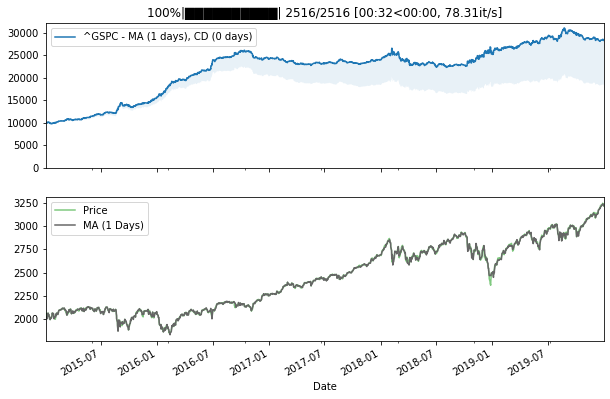

In [7]:
bt = builder.strategies([MAStrategy('^GSPC',1,0,no_log=True)]).slippage().build()
bt['2015-1-1':'2020-1-1'].run()

In [8]:
bt.summary

,Max Drawdown (%),Annual Return,Portfolio Value (Last Value),Total Value (Last Value),Total Return (%) (Last Value),Daily Profit/Loss (Last Value)
Backtest,,,,,,
"^GSPC - MA (1 days), CD (0 days) (lower bound)",-27.266620,1.128103,15973.746320,18256.626462,82.566265,-124.650650
"^GSPC - MA (1 days), CD (0 days)",-16.081719,1.230159,25596.638672,28135.337158,181.353372,-173.681641
